# Asynchronous Bounded Confidence Generator 
## (observed interactions)
In this notebook we generate a synthetic dataset from the generative model of a bounded confidence.

Input:
- initial opinions of the users
- bound of confidence eps in (0,0.5)
- convergence parameter mu in (0,0.5)

BC Model:
- at each timestep a user _u_ extract one neighbor _v_.
    * If |_u_ - _v_| < eps, then xu = xu + mu(xv - xu), xv = xv + mu(xu - xv) 
    * If |_u_ - _v_| > eps, then xu = xu
    
Generative model.
Each edge is denoted as e = (u,v,t,s), where s=1 if the interaction occurs, s=0 if it does not (opinions are not influenced each other).
At each time:
- pick a node u
- pick a node v
- k = sigmoide(eps - |xu - xv|)
- s=1 with probability k, 0 otherwise
- if s=1, xu = xu + mu(xv - xu), xv = xv + mu(xu - xv)

We assume to be able to observe E={e = (u,v,t,s)}

In [1]:
!python --version

Python 3.9.12


In [22]:
import sys
sys.path += ['../src/']
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def simulator(N, T, edge_per_t, epsilon, mu, seed = None, x0 = []):
    if seed != None:
        np.random.seed(seed)
    if len(x0) == 0:
        x0 = np.random.uniform(size = [N])
    
    u_v_t_s = torch.zeros(T - 1, edge_per_t, 3)
    t = 0
    X = [x0] #all opinions of the users
    for t in range(T - 1):
        xt = X[-1]
        for new_edge in range(edge_per_t):
            #xt = X[-1] # opinion of the users at previous time

            xt_cp = xt.copy()

            u = np.random.randint(N) #pick a user
            while True:
                v = np.random.randint(N)
                if u != v: 
                    break
            dist = np.abs(xt[u] - xt[v])

            if dist < epsilon:
                xt_cp[v] += mu * (xt[u] - xt[v])
                xt_cp[u] += mu * (xt[v] - xt[u])
                u_v_t_s[t,new_edge] = torch.Tensor([u, v, 1])
                
            else:
                u_v_t_s[t,new_edge] = torch.Tensor([u, v, 0])
                            
            xt = xt_cp

        X.append(xt_cp)

    X = np.vstack(X)
    return X, u_v_t_s.long()

In [3]:
#define also a stochastic BC model, where P(s = 1|xu, xv) = sigmoid_rho(epsilon - abs(xu - xv))
def simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness = 10, seed = None, x0 = []):
    if seed != None:
        np.random.seed(seed)
    if len(x0) == 0:
        x0 = np.random.uniform(size = [N])
    
    u_v_t_s = torch.zeros(T - 1, edge_per_t, 3)
    t = 0
    X = [x0] #all opinions of the users
    for t in range(T - 1):
        xt = X[-1]
        for new_edge in range(edge_per_t):
            #xt = X[-1] # opinion of the users at previous time

            xt_cp = xt.copy()

            u = np.random.randint(N) #pick a user
            while True:
                v = np.random.randint(N)
                if u != v: 
                    break
            dist = np.abs(xt[u] - xt[v])

            if torch.rand([]) < torch.sigmoid(torch.Tensor([steepness * (epsilon - dist)])):
                xt_cp[v] += mu * (xt[u] - xt[v])
                xt_cp[u] += mu * (xt[v] - xt[u])
                u_v_t_s[t,new_edge] = torch.Tensor([u, v, 1])
                
            else:
                u_v_t_s[t,new_edge] = torch.Tensor([u, v, 0])
                
            xt = xt_cp

        X.append(xt_cp)

    X = np.vstack(X)
    return X, u_v_t_s.long()


In [4]:
#create a plot with all the opinion time trajectories of all users
def print_opinion_trajectory(X, figsize = (5,5)):
    fig, ax = plt.subplots(figsize = figsize)
    ax.plot(np.matrix(X))
    
    fig.show()

In [5]:
N, T, edge_per_t = 2000, 5000, 10
epsilon, mu = 0.25, 0.5


In [6]:
X, edges = simulator(N, T, edge_per_t, epsilon, mu, seed = None, x0 = [])

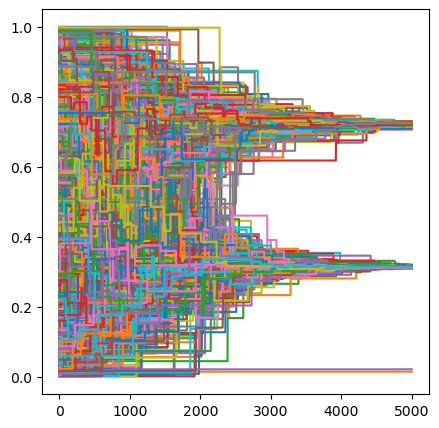

In [7]:
print_opinion_trajectory(X)

In [8]:
X_stoch, edges_stoch = simulator_stoch(N, T, edge_per_t, epsilon, mu, seed = None, x0 = [])

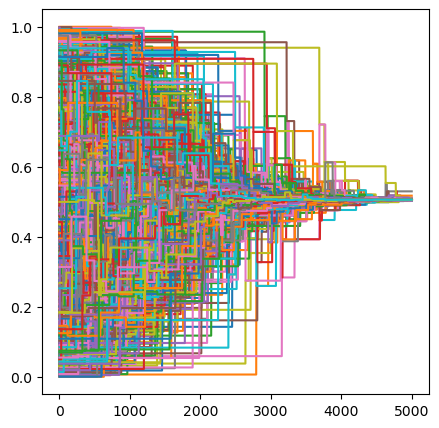

In [9]:
print_opinion_trajectory(X_stoch)

In [15]:
X[0]

array([0.44047841, 0.06609376, 0.01472698, ..., 0.51600136, 0.5831563 ,
       0.22371111])

In [16]:
edges[0]

tensor([[  47, 1330,    1],
        [ 537,  829,    0],
        [1054, 1017,    0],
        [ 423,  948,    1],
        [ 143,  948,    1],
        [ 721, 1218,    0],
        [ 995,  982,    1],
        [1229,  733,    0],
        [1608,  506,    0],
        [ 532,  617,    1]])

In [25]:
np.shape(X), edges.size()

((5000, 2000), torch.Size([4999, 10, 3]))

In [46]:
import simulator_BC as sim_bc
from time import time
from tqdm import tqdm

In [36]:
t0 = time()
for k in range(100000):
    u,v,t,s = sim_bc.convert_edges_uvts(edges[np.random.choice(np.arange(T - 1), 20)])
t1 = time()

In [42]:
t0 = time()
uvts = sim_bc.convert_edges_uvts(edges)
for k in range(100000):
    q = np.random.choice(np.arange(T - 1), 20)
    u,v,t,s = uvts[:,q]
t1 = time()

In [43]:
t1 - t0

3.7991156578063965

In [50]:
def fun(x):
    for k in tqdm(range(x)):
        a = 1
    for k in tqdm(range(x)):
        a = 1
    return a

In [51]:
import sys
import os

old_stdout = sys.stdout # backup current stdout
sys.stdout = open(os.devnull, "w")

fun(10)

sys.stdout = old_stdout

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 262144.00it/s]
